## 1. Setup and Imports

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# SpotOptim
from spotoptim import SpotOptim

# Surrogate models
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# For metrics
from sklearn.metrics import mean_squared_error, r2_score

# Set random seed
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ All packages imported successfully!")

✓ All packages imported successfully!


## 2. What is a Surrogate Model?

### Definition

A **surrogate model** (also called metamodel, emulator, or response surface) is a fast approximation of an expensive function:

$$\hat{f}(\mathbf{x}) \approx f(\mathbf{x})$$

### Why Do We Need Surrogates?

Consider these scenarios:
- **Computational simulations**: CFD, FEA (hours per evaluation)
- **Physical experiments**: Wind tunnel tests, drug trials (days/weeks)
- **Machine learning training**: Hyperparameter tuning (minutes to hours)
- **Real-world processes**: Manufacturing optimization (costly)

### The Surrogate Modeling Workflow

```
1. Sample Design Points (LHD) ────────────► X₀, y₀
                                            │
2. Fit Surrogate Model ────────────────────┤
                                            │
3. Predict at New Locations ───────────────► ŷ*, σ*
                                            │
4. Optimize Surrogate (cheap!) ────────────► x_next
                                            │
5. Evaluate True Function ─────────────────► y_next
                                            │
6. Update Surrogate ────────────────────────┘
   (back to step 2)
```

## 3. A Simple 1D Example

Let's build intuition with a simple 1D function.

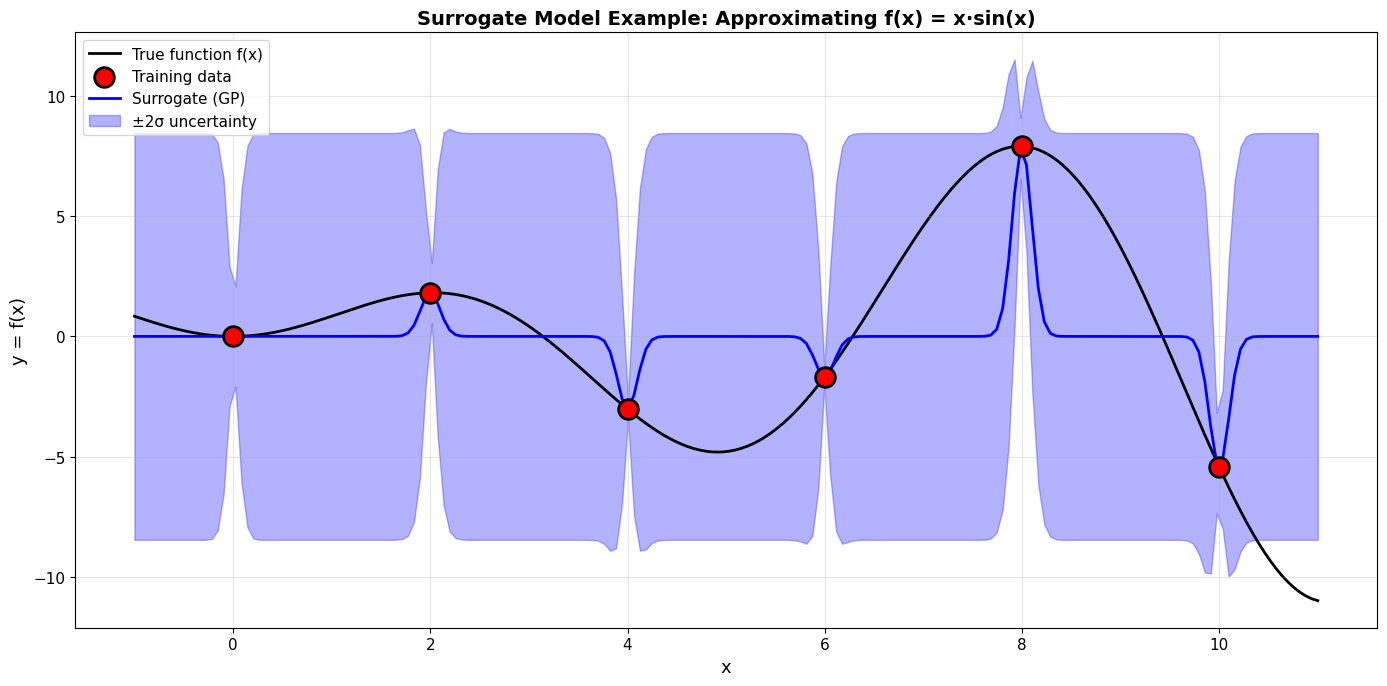


📊 Key Observations:
1. Surrogate interpolates training data perfectly (GP property)
2. Uncertainty is LOW near training points (we have data)
3. Uncertainty is HIGH far from training points (we're guessing)
4. Surrogate captures the function's general behavior


In [14]:
# Define a simple 1D test function
def test_function_1d(x):
    """1D function: f(x) = x*sin(x) + noise"""
    return x * np.sin(x)

# Generate training data (sparse samples)
X_train = np.array([0, 2, 4, 6, 8, 10]).reshape(-1, 1)
y_train = test_function_1d(X_train.ravel())

# Generate test data (dense for visualization)
X_test = np.linspace(-1, 11, 200).reshape(-1, 1)
y_true = test_function_1d(X_test.ravel())

# Fit a simple surrogate: Gaussian Process
kernel = ConstantKernel(1.0) * RBF(length_scale=.1, length_scale_bounds=(1e-9, 1e6))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, random_state=42)
gp.fit(X_train, y_train)

# Predict on test data
y_pred, y_std = gp.predict(X_test, return_std=True)

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# True function
ax.plot(X_test, y_true, 'k-', linewidth=2, label='True function f(x)', zorder=1)

# Training points
ax.scatter(X_train, y_train, s=200, c='red', marker='o', edgecolors='black', 
           linewidth=2, label='Training data', zorder=5)

# Surrogate prediction
ax.plot(X_test, y_pred, 'b-', linewidth=2, label='Surrogate (GP)', zorder=2)

# Uncertainty (±2σ ≈ 95% confidence)
ax.fill_between(X_test.ravel(), y_pred - 2*y_std, y_pred + 2*y_std, 
                alpha=0.3, color='blue', label='±2σ uncertainty', zorder=0)

ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('y = f(x)', fontsize=13)
ax.set_title('Surrogate Model Example: Approximating f(x) = x·sin(x)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("1. Surrogate interpolates training data perfectly (GP property)")
print("2. Uncertainty is LOW near training points (we have data)")
print("3. Uncertainty is HIGH far from training points (we're guessing)")
print("4. Surrogate captures the function's general behavior")

## 4. Types of Surrogate Models

Different surrogate models have different properties. Let's compare several popular choices:

### 4.1 Model Types

| Model | Interpolation | Uncertainty | Smoothness | Computational Cost |
|-------|---------------|-------------|------------|-------------------|
| **Gaussian Process** | Yes | Yes | High | O(n³) |
| **Random Forest** | No | Yes (ensemble) | Medium | O(n log n) |
| **Radial Basis Functions** | Yes | No | High | O(n³) |
| **Polynomial Regression** | No | Limited | High | O(n) |
| **Neural Networks** | No | Yes (Bayesian) | High | Varies |

### 4.2 Comparing Models on 1D Function

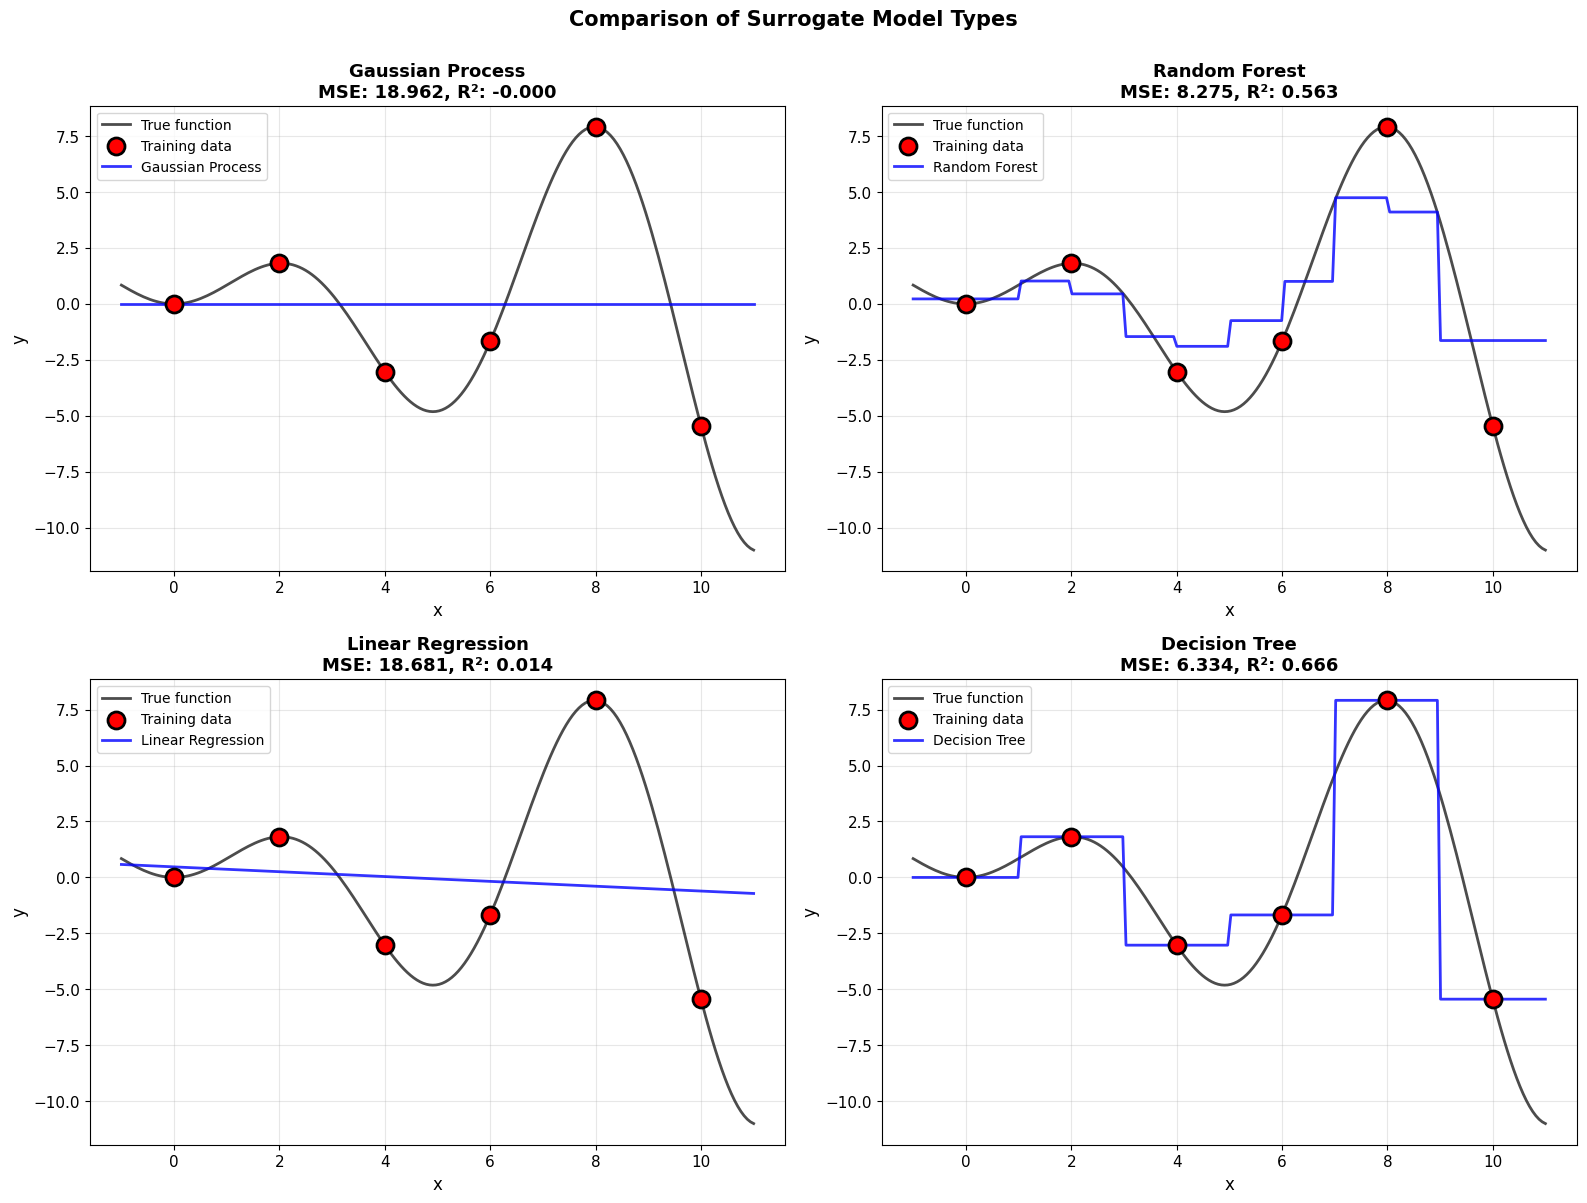


🔍 Model Comparison:

1. Gaussian Process:
   ✓ Smooth interpolation
   ✓ Captures function behavior well
   ✓ Provides uncertainty estimates

2. Random Forest:
   ✓ Good fit to data
   ✗ Piecewise constant predictions
   ✓ Fast for large datasets

3. Linear Regression:
   ✗ Too simple for nonlinear function
   ✓ Very fast

4. Decision Tree:
   ✓ Captures some structure
   ✗ Non-smooth predictions
   ✗ Can overfit


In [3]:
# Same training data as before
X_train_1d = np.array([0, 2, 4, 6, 8, 10]).reshape(-1, 1)
y_train_1d = test_function_1d(X_train_1d.ravel())
X_test_1d = np.linspace(-1, 11, 200).reshape(-1, 1)
y_true_1d = test_function_1d(X_test_1d.ravel())

# Fit different surrogate models
models = {
    'Gaussian Process': GaussianProcessRegressor(
        kernel=ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1)),
        n_restarts_optimizer=50,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    ),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(
        max_depth=5,
        random_state=42
    )
}

# Fit and predict
predictions = {}
for name, model in models.items():
    model.fit(X_train_1d, y_train_1d)
    y_pred = model.predict(X_test_1d)
    predictions[name] = y_pred

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx]
    
    # True function
    ax.plot(X_test_1d, y_true_1d, 'k-', linewidth=2, label='True function', alpha=0.7)
    
    # Training points
    ax.scatter(X_train_1d, y_train_1d, s=150, c='red', marker='o', 
               edgecolors='black', linewidth=2, label='Training data', zorder=5)
    
    # Surrogate prediction
    ax.plot(X_test_1d, y_pred, 'b-', linewidth=2, label=f'{name}', alpha=0.8)
    
    # Compute MSE
    mse = mean_squared_error(y_true_1d, y_pred)
    r2 = r2_score(y_true_1d, y_pred)
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title(f'{name}\nMSE: {mse:.3f}, R²: {r2:.3f}', 
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparison of Surrogate Model Types', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n🔍 Model Comparison:")
print("\n1. Gaussian Process:")
print("   ✓ Smooth interpolation")
print("   ✓ Captures function behavior well")
print("   ✓ Provides uncertainty estimates")
print("\n2. Random Forest:")
print("   ✓ Good fit to data")
print("   ✗ Piecewise constant predictions")
print("   ✓ Fast for large datasets")
print("\n3. Linear Regression:")
print("   ✗ Too simple for nonlinear function")
print("   ✓ Very fast")
print("\n4. Decision Tree:")
print("   ✓ Captures some structure")
print("   ✗ Non-smooth predictions")
print("   ✗ Can overfit")

## 5. Gaussian Process Regression (Kriging)

**Gaussian Processes (GP)** are the gold standard for surrogate modeling in optimization. Also known as **Kriging** in geostatistics.

### 5.1 What is a Gaussian Process?

A Gaussian Process is a probability distribution over **functions**:

$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}'))$$

Where:
- $m(\mathbf{x})$ is the **mean function** (often 0)
- $k(\mathbf{x}, \mathbf{x}')$ is the **covariance function** (kernel)

### 5.2 Key Properties

1. **Interpolation**: GP passes exactly through training points (with no noise)
2. **Uncertainty**: Provides predictive variance $\sigma^2(\mathbf{x}^*)$
3. **Smoothness**: Determined by kernel choice
4. **Bayesian**: Naturally handles uncertainty quantification

### 5.3 GP Prediction Formulas

Given training data $(\mathbf{X}, \mathbf{y})$, prediction at $\mathbf{x}^*$:

**Mean (prediction):**
$$\mu(\mathbf{x}^*) = \mathbf{k}^T(\mathbf{x}^*) [\mathbf{K} + \sigma_n^2\mathbf{I}]^{-1} \mathbf{y}$$

**Variance (uncertainty):**
$$\sigma^2(\mathbf{x}^*) = k(\mathbf{x}^*, \mathbf{x}^*) - \mathbf{k}^T(\mathbf{x}^*) [\mathbf{K} + \sigma_n^2\mathbf{I}]^{-1} \mathbf{k}(\mathbf{x}^*)$$

Where:
- $\mathbf{K}$ is the covariance matrix between training points
- $\mathbf{k}(\mathbf{x}^*)$ is the covariance vector between $\mathbf{x}^*$ and training points
- $\sigma_n^2$ is the noise variance

## 6. Kernel Functions (Covariance Functions)

The **kernel** determines the properties of the GP surrogate. It encodes our assumptions about the function.

### 6.1 Popular Kernels

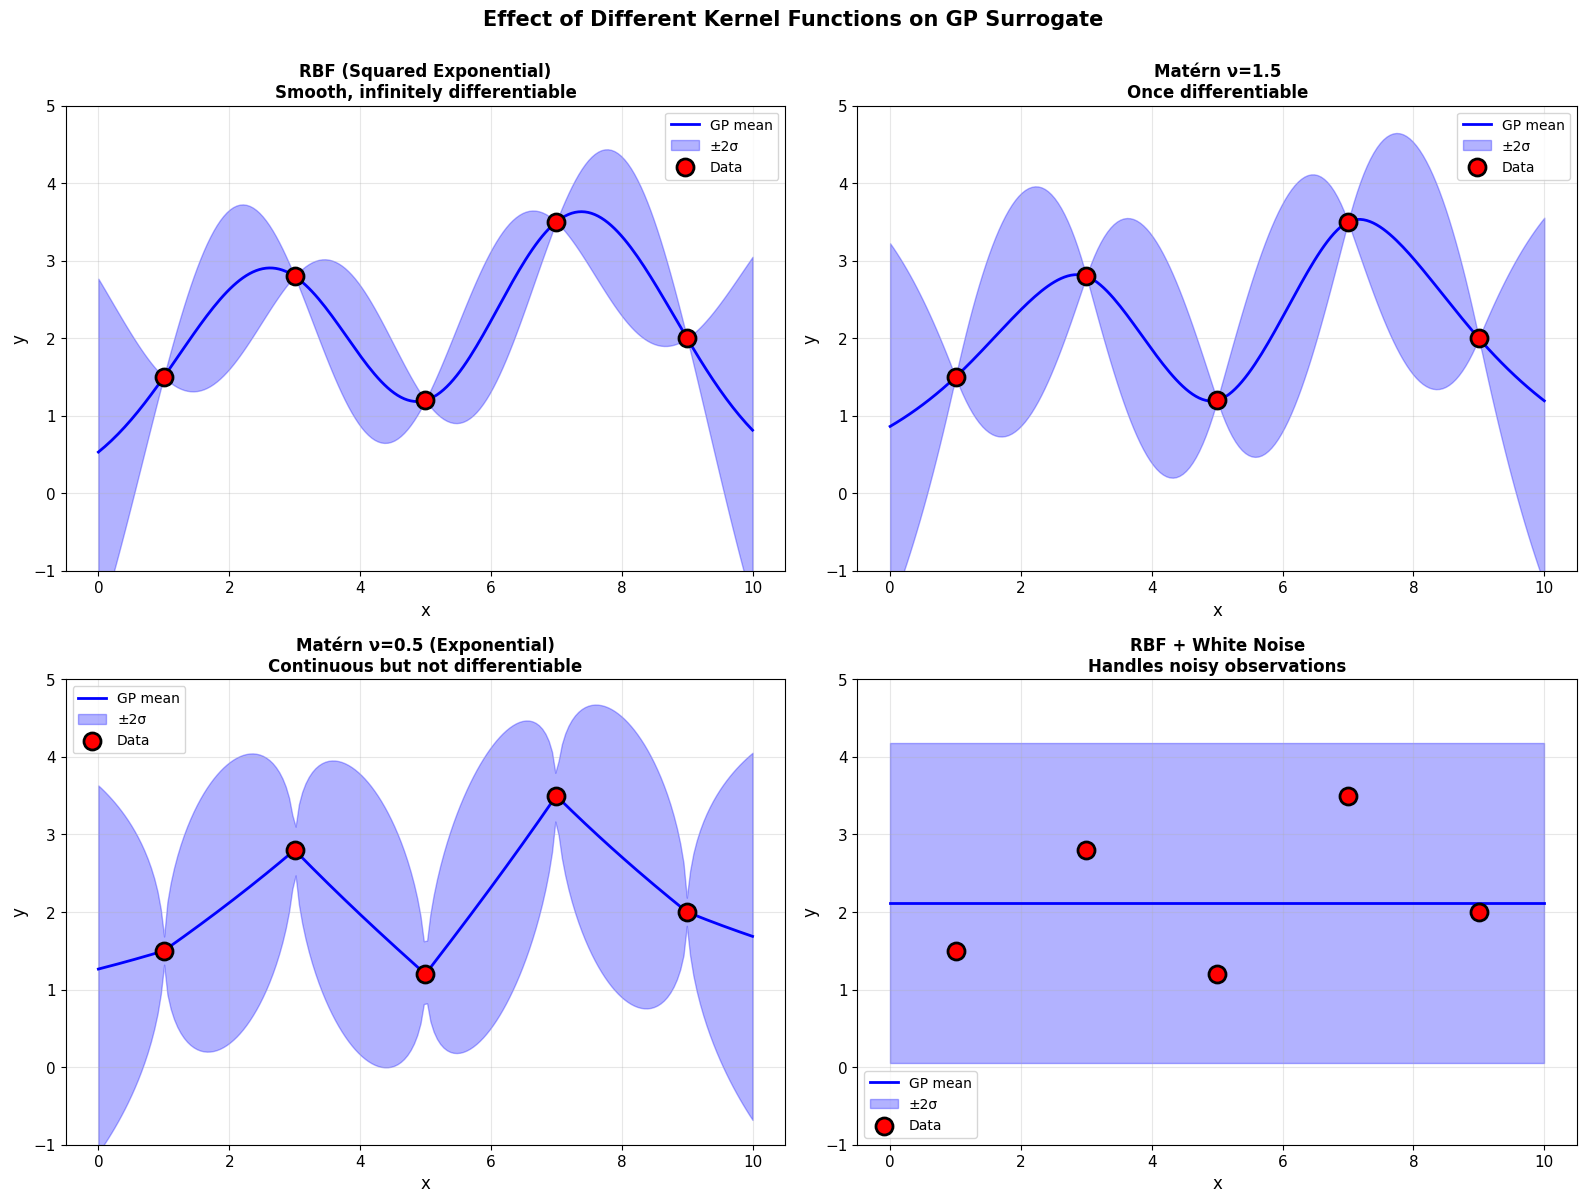


🔧 Kernel Selection Guide:

1. RBF (Squared Exponential): Default choice
   - Very smooth predictions
   - Good for most engineering problems

2. Matérn ν=2.5 or ν=1.5: More flexible
   - Less smooth than RBF
   - Better for functions with kinks

3. Matérn ν=0.5 (Exponential): Rough functions
   - Only continuous
   - Use for discontinuous or very rough functions

4. Add White Noise: For noisy observations
   - Doesn't force interpolation
   - Use when measurements have noise


In [4]:
# Generate sample data
X_sample = np.array([1, 3, 5, 7, 9]).reshape(-1, 1)
y_sample = np.array([1.5, 2.8, 1.2, 3.5, 2.0])
X_plot = np.linspace(0, 10, 200).reshape(-1, 1)

# Different kernels
kernels = {
    'RBF (Squared Exponential)\nSmooth, infinitely differentiable': 
        ConstantKernel(1.0) * RBF(length_scale=1.5),
    
    'Matérn ν=1.5\nOnce differentiable': 
        ConstantKernel(1.0) * Matern(length_scale=1.5, nu=1.5),
    
    'Matérn ν=0.5 (Exponential)\nContinuous but not differentiable': 
        ConstantKernel(1.0) * Matern(length_scale=1.5, nu=0.5),
    
    'RBF + White Noise\nHandles noisy observations': 
        ConstantKernel(1.0) * RBF(length_scale=1.5) + WhiteKernel(noise_level=0.5)
}

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, kernel) in enumerate(kernels.items()):
    ax = axes[idx]
    
    # Fit GP
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gp.fit(X_sample, y_sample)
    
    # Predict
    y_pred, y_std = gp.predict(X_plot, return_std=True)
    
    # Plot
    ax.plot(X_plot, y_pred, 'b-', linewidth=2, label='GP mean')
    ax.fill_between(X_plot.ravel(), y_pred - 2*y_std, y_pred + 2*y_std,
                     alpha=0.3, color='blue', label='±2σ')
    ax.scatter(X_sample, y_sample, s=150, c='red', marker='o',
               edgecolors='black', linewidth=2, label='Data', zorder=5)
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1, 5)

plt.suptitle('Effect of Different Kernel Functions on GP Surrogate', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n🔧 Kernel Selection Guide:")
print("\n1. RBF (Squared Exponential): Default choice")
print("   - Very smooth predictions")
print("   - Good for most engineering problems")
print("\n2. Matérn ν=2.5 or ν=1.5: More flexible")
print("   - Less smooth than RBF")
print("   - Better for functions with kinks")
print("\n3. Matérn ν=0.5 (Exponential): Rough functions")
print("   - Only continuous")
print("   - Use for discontinuous or very rough functions")
print("\n4. Add White Noise: For noisy observations")
print("   - Doesn't force interpolation")
print("   - Use when measurements have noise")

## 7. SpotOptim's Surrogate Construction

Now let's see how **SpotOptim** constructs and uses surrogate models.

### 7.1 The `_fit_surrogate()` Method

SpotOptim uses the `_fit_surrogate()` method to train the surrogate on current data:

In [5]:
# Define a 2D test function
def branin(X):
    """Branin function (2D benchmark)"""
    X = np.atleast_2d(X)
    x1 = X[:, 0]
    x2 = X[:, 1]
    
    a = 1
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    
    y = a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*np.cos(x1) + s
    return y

# Create SpotOptim instance
opt = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    n_initial=15,
    surrogate=GaussianProcessRegressor(
        kernel=ConstantKernel(1.0) * Matern(nu=2.5),
        n_restarts_optimizer=10,
        normalize_y=True
    ),
    seed=42
)

# Generate initial design
X0 = opt._set_initial_design()
y0 = branin(X0)

print(f"Generated {len(X0)} initial samples")
print(f"\nFitting surrogate model...")

# Fit surrogate (this is what SpotOptim does internally)
opt._fit_surrogate(X0, y0)

print(f"✓ Surrogate fitted successfully!")
print(f"\nSurrogate model: {type(opt.surrogate).__name__}")
print(f"Kernel: {opt.surrogate.kernel_}")
print(f"\nNow the surrogate can predict at any point in the design space!")

Generated 15 initial samples

Fitting surrogate model...
✓ Surrogate fitted successfully!

Surrogate model: GaussianProcessRegressor
Kernel: 1.89**2 * Matern(length_scale=7.17, nu=2.5)

Now the surrogate can predict at any point in the design space!


### 7.2 The `_predict_with_uncertainty()` Method

SpotOptim's `_predict_with_uncertainty()` method makes predictions with uncertainty estimates:

In [6]:
# Choose some test points
X_test = np.array([
    [0, 5],      # Interior point
    [-3, 12],    # Near optimum
    [8, 2],      # Another region
    [5, 14]      # Edge of space
])

# Predict using SpotOptim's method
y_pred, y_std = opt._predict_with_uncertainty(X_test)

# Compare with true values
y_true = branin(X_test)

# Display results
print("\n📊 Surrogate Predictions with Uncertainty:\n")
print(f"{'Point':<15} {'True Value':<12} {'Predicted':<12} {'Std Dev':<12} {'Error':<12}")
print("=" * 70)

for i in range(len(X_test)):
    point_str = f"({X_test[i,0]:.1f}, {X_test[i,1]:.1f})"
    error = abs(y_true[i] - y_pred[i])
    print(f"{point_str:<15} {y_true[i]:<12.4f} {y_pred[i]:<12.4f} {y_std[i]:<12.4f} {error:<12.4f}")

print("\n💡 Observations:")
print("- Predictions close to true values (good surrogate!)")
print("- Uncertainty (std dev) tells us how confident the model is")
print("- Errors are generally within 1-2 standard deviations")


📊 Surrogate Predictions with Uncertainty:

Point           True Value   Predicted    Std Dev      Error       
(0.0, 5.0)      20.6021      -17.5385     17.2203      38.1406     
(-3.0, 12.0)    0.4979       51.5905      24.7137      51.0926     
(8.0, 2.0)      8.8187       3.0091       10.4243      5.8097      
(5.0, 14.0)     174.7292     169.8217     16.5786      4.9075      

💡 Observations:
- Predictions close to true values (good surrogate!)
- Uncertainty (std dev) tells us how confident the model is
- Errors are generally within 1-2 standard deviations


### 7.3 Visualizing the Fitted Surrogate

Let's visualize the surrogate model SpotOptim constructed:

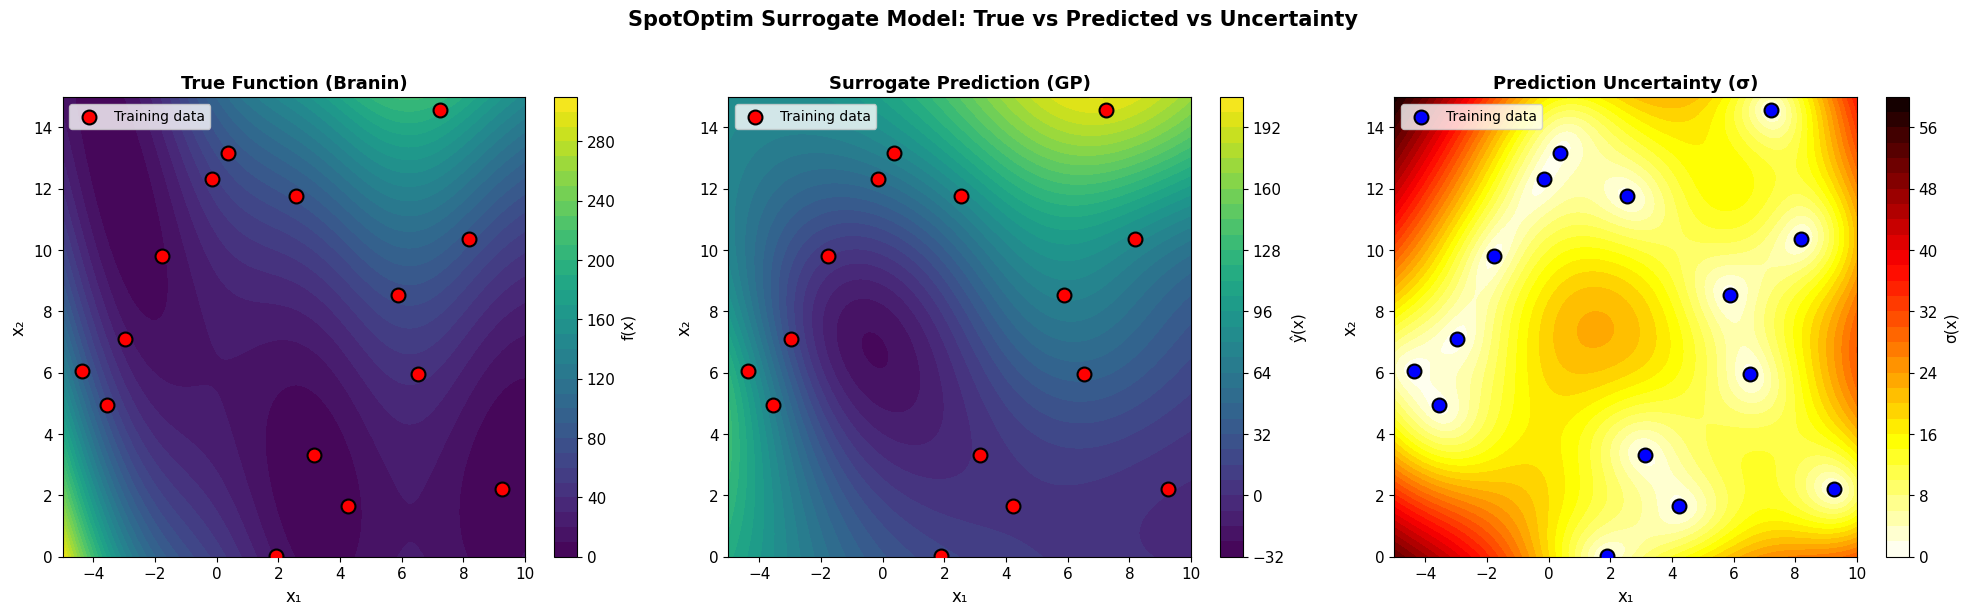


🎯 Key Insights:

1. Surrogate captures the general structure of the true function
2. Uncertainty is LOW near training data (blue dots)
3. Uncertainty is HIGH in unexplored regions
4. This uncertainty guides where to sample next (Tutorial 5!)


In [7]:
# Create grid for visualization
x1_range = np.linspace(-5, 10, 100)
x2_range = np.linspace(0, 15, 100)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
X_grid = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])

# True function
y_true_grid = branin(X_grid).reshape(X1_grid.shape)

# Surrogate prediction
y_pred_grid, y_std_grid = opt._predict_with_uncertainty(X_grid)
y_pred_grid = y_pred_grid.reshape(X1_grid.shape)
y_std_grid = y_std_grid.reshape(X1_grid.shape)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: True function
im1 = axes[0].contourf(X1_grid, X2_grid, y_true_grid, levels=30, cmap='viridis')
axes[0].scatter(X0[:, 0], X0[:, 1], c='red', s=100, edgecolors='black', 
                linewidth=1.5, label='Training data', zorder=5)
axes[0].set_xlabel('x₁', fontsize=12)
axes[0].set_ylabel('x₂', fontsize=12)
axes[0].set_title('True Function (Branin)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
plt.colorbar(im1, ax=axes[0], label='f(x)')

# Plot 2: Surrogate prediction
im2 = axes[1].contourf(X1_grid, X2_grid, y_pred_grid, levels=30, cmap='viridis')
axes[1].scatter(X0[:, 0], X0[:, 1], c='red', s=100, edgecolors='black', 
                linewidth=1.5, label='Training data', zorder=5)
axes[1].set_xlabel('x₁', fontsize=12)
axes[1].set_ylabel('x₂', fontsize=12)
axes[1].set_title('Surrogate Prediction (GP)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
plt.colorbar(im2, ax=axes[1], label='ŷ(x)')

# Plot 3: Prediction uncertainty
im3 = axes[2].contourf(X1_grid, X2_grid, y_std_grid, levels=30, cmap='hot_r')
axes[2].scatter(X0[:, 0], X0[:, 1], c='blue', s=100, edgecolors='black', 
                linewidth=1.5, label='Training data', zorder=5)
axes[2].set_xlabel('x₁', fontsize=12)
axes[2].set_ylabel('x₂', fontsize=12)
axes[2].set_title('Prediction Uncertainty (σ)', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=10)
plt.colorbar(im3, ax=axes[2], label='σ(x)')

plt.suptitle('SpotOptim Surrogate Model: True vs Predicted vs Uncertainty', 
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n🎯 Key Insights:")
print("\n1. Surrogate captures the general structure of the true function")
print("2. Uncertainty is LOW near training data (blue dots)")
print("3. Uncertainty is HIGH in unexplored regions")
print("4. This uncertainty guides where to sample next (Tutorial 5!)")

## 8. Surrogate Model Accuracy vs. Sample Size

How does surrogate accuracy improve with more samples?

n=  5: RMSE=42.126, R²=0.3223, Max Error=246.074
n= 10: RMSE=34.839, R²=0.5365, Max Error=245.150
n= 20: RMSE=18.860, R²=0.8642, Max Error=106.109
n= 40: RMSE= 9.142, R²=0.9681, Max Error=99.487
n= 80: RMSE= 6.975, R²=0.9814, Max Error=77.329
n= 10: RMSE=34.839, R²=0.5365, Max Error=245.150
n= 20: RMSE=18.860, R²=0.8642, Max Error=106.109
n= 40: RMSE= 9.142, R²=0.9681, Max Error=99.487
n= 80: RMSE= 6.975, R²=0.9814, Max Error=77.329


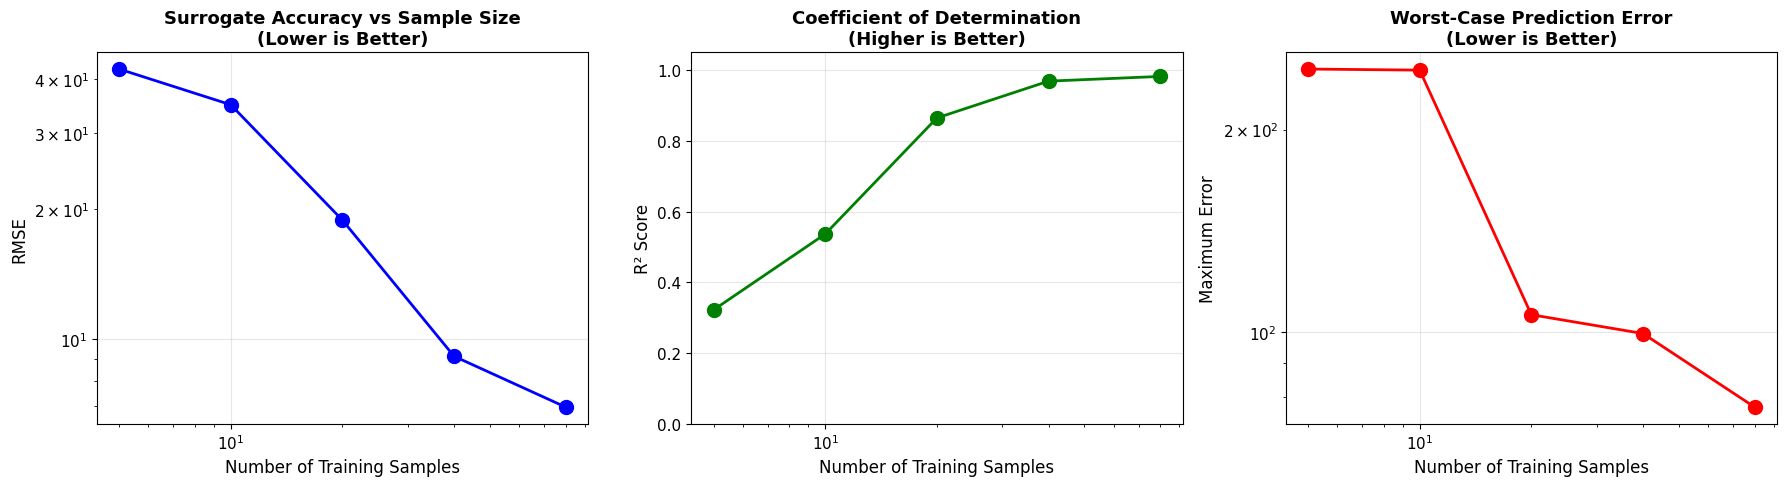


📈 Observations:
- RMSE decreases with more samples (better accuracy)
- R² approaches 1 (perfect prediction)
- Diminishing returns after ~40 samples for this function
- Trade-off: accuracy vs. computational cost


In [8]:
# Test different sample sizes
sample_sizes = [5, 10, 20, 40, 80]
n_test = 500  # Fixed test set

# Generate test set
np.random.seed(123)
X_test_eval = np.random.uniform(low=[-5, 0], high=[10, 15], size=(n_test, 2))
y_test_eval = branin(X_test_eval)

results = []

for n in sample_sizes:
    # Create optimizer with n initial samples
    opt_n = SpotOptim(
        fun=branin,
        bounds=[(-5, 10), (0, 15)],
        n_initial=n,
        max_iter=100,
        surrogate=GaussianProcessRegressor(
            kernel=ConstantKernel(1.0) * Matern(nu=2.5),
            n_restarts_optimizer=10,
            normalize_y=True,
            random_state=42,
        ),
        seed=42
    )
    
    # Generate samples and fit
    X_train_n = opt_n._set_initial_design()
    y_train_n = branin(X_train_n)
    opt_n._fit_surrogate(X_train_n, y_train_n)
    
    # Evaluate on test set
    y_pred_n, _ = opt_n._predict_with_uncertainty(X_test_eval)
    
    # Compute metrics
    mse = mean_squared_error(y_test_eval, y_pred_n)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_eval, y_pred_n)
    max_error = np.max(np.abs(y_test_eval - y_pred_n))
    
    results.append({
        'n_samples': n,
        'rmse': rmse,
        'r2': r2,
        'max_error': max_error
    })
    
    print(f"n={n:3d}: RMSE={rmse:6.3f}, R²={r2:6.4f}, Max Error={max_error:6.3f}")

# Plot results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sample_sizes_arr = [r['n_samples'] for r in results]
rmse_arr = [r['rmse'] for r in results]
r2_arr = [r['r2'] for r in results]
max_error_arr = [r['max_error'] for r in results]

# RMSE
axes[0].plot(sample_sizes_arr, rmse_arr, 'o-', linewidth=2, markersize=10, color='blue')
axes[0].set_xlabel('Number of Training Samples', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('Surrogate Accuracy vs Sample Size\n(Lower is Better)', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# R²
axes[1].plot(sample_sizes_arr, r2_arr, 'o-', linewidth=2, markersize=10, color='green')
axes[1].set_xlabel('Number of Training Samples', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Coefficient of Determination\n(Higher is Better)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')
axes[1].set_ylim([0, 1.05])

# Max Error
axes[2].plot(sample_sizes_arr, max_error_arr, 'o-', linewidth=2, markersize=10, color='red')
axes[2].set_xlabel('Number of Training Samples', fontsize=12)
axes[2].set_ylabel('Maximum Error', fontsize=12)
axes[2].set_title('Worst-Case Prediction Error\n(Lower is Better)', 
                  fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xscale('log')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print("\n📈 Observations:")
print("- RMSE decreases with more samples (better accuracy)")
print("- R² approaches 1 (perfect prediction)")
print("- Diminishing returns after ~40 samples for this function")
print("- Trade-off: accuracy vs. computational cost")

## 9. Advanced: Surrogate Model Selection

SpotOptim allows you to specify different surrogate models. Let's compare:

### 9.1 Different Surrogates on Same Problem

In [9]:
# Define different surrogates
surrogates = {
    'GP (Matérn ν=2.5)': GaussianProcessRegressor(
        kernel=ConstantKernel(1.0) * Matern(nu=2.5, length_scale=1.0),
        n_restarts_optimizer=10,
        normalize_y=True,
        random_state=42
    ),
    'GP (RBF)': GaussianProcessRegressor(
        kernel=ConstantKernel(1.0) * RBF(length_scale=1.0),
        n_restarts_optimizer=10,
        normalize_y=True,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        random_state=42
    )
}

# Same training data for all
n_train = 20
opt_base = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    n_initial=n_train,
    seed=42
)
X_train_compare = opt_base._set_initial_design()
y_train_compare = branin(X_train_compare)

# Test on grid
x1_test = np.linspace(-5, 10, 80)
x2_test = np.linspace(0, 15, 80)
X1_test, X2_test = np.meshgrid(x1_test, x2_test)
X_test_grid = np.column_stack([X1_test.ravel(), X2_test.ravel()])
y_true_test = branin(X_test_grid)

# Compare surrogates
print("\n🔬 Comparing Different Surrogate Models:\n")
print(f"{'Model':<25} {'RMSE':<10} {'R²':<10} {'Fit Time (s)':<15}")
print("=" * 65)

import time

for name, surrogate in surrogates.items():
    # Time the fitting
    start = time.time()
    surrogate.fit(X_train_compare, y_train_compare)
    fit_time = time.time() - start
    
    # Predict
    y_pred_compare = surrogate.predict(X_test_grid)
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_compare))
    r2 = r2_score(y_true_test, y_pred_compare)
    
    print(f"{name:<25} {rmse:<10.4f} {r2:<10.4f} {fit_time:<15.4f}")

print("\n💡 Model Selection Guidelines:")
print("\n1. Gaussian Process (Matérn): Best for smooth functions")
print("   - Provides uncertainty estimates")
print("   - Good interpolation properties")
print("   - Slower for large datasets (>1000 points)")
print("\n2. Random Forest: Good for complex landscapes")
print("   - Fast for large datasets")
print("   - Handles discontinuities well")
print("   - No native uncertainty (can use ensemble variance)")
print("\n3. SpotOptim Default: GP with Matérn kernel")
print("   - Good balance for most problems")


🔬 Comparing Different Surrogate Models:

Model                     RMSE       R²         Fit Time (s)   
GP (Matérn ν=2.5)         18.9099    0.8700     0.0285         
GP (RBF)                  22.5214    0.8156     0.0265         
Random Forest             34.4596    0.5684     0.0226         

💡 Model Selection Guidelines:

1. Gaussian Process (Matérn): Best for smooth functions
   - Provides uncertainty estimates
   - Good interpolation properties
   - Slower for large datasets (>1000 points)

2. Random Forest: Good for complex landscapes
   - Fast for large datasets
   - Handles discontinuities well
   - No native uncertainty (can use ensemble variance)

3. SpotOptim Default: GP with Matérn kernel
   - Good balance for most problems


## 10. Practical Tips for Surrogate Modeling

### 10.1 Sample Size Guidelines

**Rule of Thumb**: For a $d$-dimensional problem:
- Minimum: $n \geq 10d$ samples
- Better: $n \geq 20d$ samples
- Complex functions: $n \geq 50d$ samples

### 10.2 When to Use Each Surrogate

| Scenario | Recommended Surrogate |
|----------|----------------------|
| Smooth expensive functions | Gaussian Process (GP) |
| Noisy observations | GP with White Kernel |
| Large datasets (>1000 points) | Random Forest |
| Discontinuous functions | Random Forest or Decision Tree |
| Need uncertainty | Gaussian Process |
| Very high dimensions (>20D) | Random Forest or Neural Network |

### 10.3 SpotOptim Best Practices

In [10]:
# Example: Configuring SpotOptim with custom surrogate

# For smooth, expensive functions (DEFAULT)
opt_smooth = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    n_initial=20,  # 10d rule: 2 dims × 10 = 20
    surrogate=GaussianProcessRegressor(
        kernel=ConstantKernel(1.0) * Matern(nu=2.5),
        n_restarts_optimizer=10,
        normalize_y=True  # Always normalize!
    ),
    seed=42
)

# For noisy functions
opt_noisy = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    n_initial=20,
    repeats_initial=3,  # Repeat evaluations for noise estimation
    surrogate=GaussianProcessRegressor(
        kernel=ConstantKernel(1.0) * Matern(nu=2.5) + WhiteKernel(),
        n_restarts_optimizer=10,
        normalize_y=True
    ),
    seed=42
)

# For large-scale problems
opt_largescale = SpotOptim(
    fun=branin,
    bounds=[(-5, 10), (0, 15)],
    n_initial=20,
    max_surrogate_points=50,  # Limit surrogate training set
    surrogate=RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        random_state=42
    ),
    seed=42
)

print("✅ SpotOptim configured for different scenarios!")
print("\n📝 Key Parameters:")
print("- n_initial: Number of initial samples (use 10d - 20d)")
print("- surrogate: Choice of surrogate model")
print("- repeats_initial: For noisy functions (>1)")
print("- max_surrogate_points: Limit for large datasets")
print("- normalize_y=True: Always normalize GP targets!")

✅ SpotOptim configured for different scenarios!

📝 Key Parameters:
- n_initial: Number of initial samples (use 10d - 20d)
- surrogate: Choice of surrogate model
- repeats_initial: For noisy functions (>1)
- max_surrogate_points: Limit for large datasets
- normalize_y=True: Always normalize GP targets!


## 11. Key Takeaways

### Summary of Surrogate Modeling

✅ **What is a Surrogate?**
- Fast approximation of expensive function
- Trained on limited data (from LHD)
- Enables efficient optimization

✅ **Why Gaussian Processes?**
- Interpolates training data
- Provides uncertainty estimates
- Smooth predictions
- Bayesian framework

✅ **SpotOptim Integration:**
- `_fit_surrogate()`: Train surrogate on current data
- `_predict_with_uncertainty()`: Make predictions with confidence
- Flexible surrogate model selection
- Automatic handling of data scaling

✅ **Best Practices:**
1. Use $10d - 20d$ initial samples
2. GP (Matérn) for most problems
3. Add White Kernel for noisy functions
4. Random Forest for large datasets
5. Always normalize_y=True for GP

### The Optimization Workflow So Far:

```
Tutorial 1: Initial Design (LHD) ─────► X₀, y₀
                                        │
Tutorial 2: Fit Surrogate ─────────────► ŷ(x), σ(x)
                                        │
Tutorial 3: Explore & Exploit ─────────► Next!
```

## 12. Looking Ahead: Next Tutorial

In **Tutorial 3: Exploring and Exploiting a Surrogate**, we'll learn:

- The exploration vs. exploitation trade-off
- How to search the surrogate for promising points
- SpotOptim's `_suggest_next_point()` method
- Acquisition function optimization
- Handling duplicate points and constraints

### Preview Question:

*Given a fitted surrogate model with uncertainty estimates, where should we evaluate next?*

That's the heart of Bayesian Optimization! 🎯

## 13. Exercises (Optional)

### Exercise 1: Kernel Comparison
Fit Gaussian Processes with different kernels (RBF, Matérn with various ν) on a 1D function of your choice. Compare:
- Prediction accuracy
- Smoothness
- Uncertainty estimates

### Exercise 2: Sample Size Study
For a 5D test function:
- Vary n_initial from 10 to 200
- Plot RMSE vs. sample size
- Find the "knee point" where improvements slow down

### Exercise 3: Noisy Function Surrogate
Add Gaussian noise to a test function:
- Compare GP with and without White Kernel
- Visualize the effect on predictions
- Which model handles noise better?

### Exercise 4: High-Dimensional Surrogate
Create a 10D optimization problem:
- Use SpotOptim with GP surrogate
- Compare with Random Forest surrogate
- Which is faster? More accurate?

### Exercise 5: Real-World Application
Apply surrogate modeling to a problem of your choice:
- Hyperparameter tuning
- Engineering design
- Scientific simulation

Document your surrogate model choice and performance.

## References

1. Forrester, A., Sobester, A., & Keane, A. (2008). *Engineering Design via Surrogate Modelling: A Practical Guide*. Wiley.

2. Rasmussen, C. E., & Williams, C. K. (2006). *Gaussian Processes for Machine Learning*. MIT Press. [Free online](http://gaussianprocess.org/gpml/)

3. Santner, T. J., Williams, B. J., & Notz, W. I. (2003). *The Design and Analysis of Computer Experiments*. Springer.

4. Sacks, J., Welch, W. J., Mitchell, T. J., & Wynn, H. P. (1989). Design and analysis of computer experiments. *Statistical Science*, 4(4), 409-423.

5. Jones, D. R., Schonlau, M., & Welch, W. J. (1998). Efficient global optimization of expensive black-box functions. *Journal of Global Optimization*, 13(4), 455-492.

6. Sequential Parameter Optimization Group. (2024). *Hyperparameter Tuning Cookbook*. [https://sequential-parameter-optimization.github.io/Hyperparameter-Tuning-Cookbook/](https://sequential-parameter-optimization.github.io/Hyperparameter-Tuning-Cookbook/)

---

**Previous:** [Tutorial 1 - Sampling Plans and LHD](01_sampling_plans_lhd.ipynb)  
**Next:** [Tutorial 3 - Exploring and Exploiting a Surrogate](03_exploring_exploiting.ipynb)